# Misura dell'equivalente in acqua

Per prima cosa collegate la sonda Termometrica DS18B20 al pc tramite il cavo usb. Il sensore offre una rappresentazione a 12 bit della temperatura letta e comunica con Arduino tramite il protocollo 1-Wire. Il codice dello Sketch per Arduino Uno è disponibile nel repository Git della scuola. Per eseguire una cella di codice è sufficiente selezionarla con il mouse e premere CTRL+INVIO.

<a href="https://datasheets.maximintegrated.com/en/ds/DS18B20.pdf"> Qui </a> potete scaricare il datasheet del sensore utilizzato.




In [62]:
import serial
import serial.tools.list_ports
import time

Dopo aver caricato i moduli per la gestione della seriale possiamo enumerare le porte. Se non sono presenti altre schede Arduino, la porta seriale sarà quasi sicuramente /dev/ttyUSB0

In [128]:
com_ports=serial.tools.list_ports.comports()
for p in com_ports:
    print(p.device)

/dev/ttyUSB1


Data la bassa frequenza di aggiornamento della  temperatura, l'interfaccia seriale della scheda Arduino è impostata a 9600bps. L'istruzione seguente apre la porta seriale ed inizia una comunicazione con Arduino a 9600bps, nel caso in cui lo sketch sia stato modificato sarà necessario aggiornare la frequenza di trasmissione dati.

In [64]:
arduino = serial.Serial('/dev/ttyUSB1', baudrate=9600, timeout=1)

Prima di iniziare l'acquisizione dati, controlliamo che la scheda si attiva e risponda alle nostre sollecitazioni. La funzione Handshake, invia il carattere h ed aspetta una risposta da Arduino. Se la connessione è attiva e funzionante, dovreste ottenere come risposta il carattere R

In [65]:
def handshake_arduino(arduino, sleep_time=1):
    time.sleep(sleep_time);
    timeout = arduino.timeout
    arduino.timeout = 2
    arduino.write('h'.encode())
    while (arduino.in_waiting < 0):
        pass
    response= arduino.read_until()
    print(response.decode().strip())
    arduino.timeout = timeout




handshake_arduino(arduino)

R


La funzione parse_raw_line, legge una linea di input fornita da Arduino, suddivide il testo in due dati, e converte il tempo da millisecondi a secondi

In [66]:
def parse_raw_line(raw_line):
    raw_line = raw_line.decode()
    if raw_line[-1] != "\n":
        raise ValueError(
            "Il messaggio inviato da Arduino deve terminare con il carattere nuova linea."
        )

    time,temp= raw_line.rstrip().split(",");

    return float(time)/1000.,float(temp)

Definisco due liste times=[] e temps=[] che conterranno i dati letti dall'interfaccia di Arduino

In [67]:
times = []
temps= []
def daq_get_values(time_base=0):
    # invio il codice per la lettura di una temperatura
    arduino.write('t'.encode())
    
    while arduino.in_waiting < 0:
        pass

    # Leggo i dati inviati tramite seriale a seguito della richiesta di lettura
    raw = arduino.read_until()
      
    # Elaboro i dati forniti, traslando il tempo iniziale 
    try:
        time,temp=parse_raw_line(raw)
        times.append(time-time_base)
        temps.append(temp)
        
    except:
        pass

Controllo il corretto funzionamento del sistema richiedendo la lettura di una temperatura

In [68]:
times = []
temps= []

daq_get_values()
print(times)
print(temps)


[407.928]
[28.81]


Carico Matplotlib per la rappresentazione dei dati 

In [84]:
import matplotlib.pyplot as plt 

%matplotlib widget
plt.rcParams['animation.html']='jshtml'


La funzione getData accetta come input il numero di secondi per cui dovrà durare la cattura dati e l'intervallo di tempo tra una lettura e la successiva, durante la lettura dell'interfaccia aggiorno il grafico dell'andamento

In [129]:
def getData(run_time,delta_t):
        
        arduino.write('n'.encode())
        time.sleep(1);
        arduino.write('r'.encode())
        time.sleep(1);
        #pulisco il buffer seriale
        arduino.read_all()
        daq_get_values()
        run=True
             
        while run:
            
            daq_get_values()
            plt.plot(times,temps,'-o',color='gray',markerfacecolor='red')
            fig.canvas.draw()
            time.sleep(delta_t)
            if times[-1]-times[0]>run_time:
                run=False
                print(times)



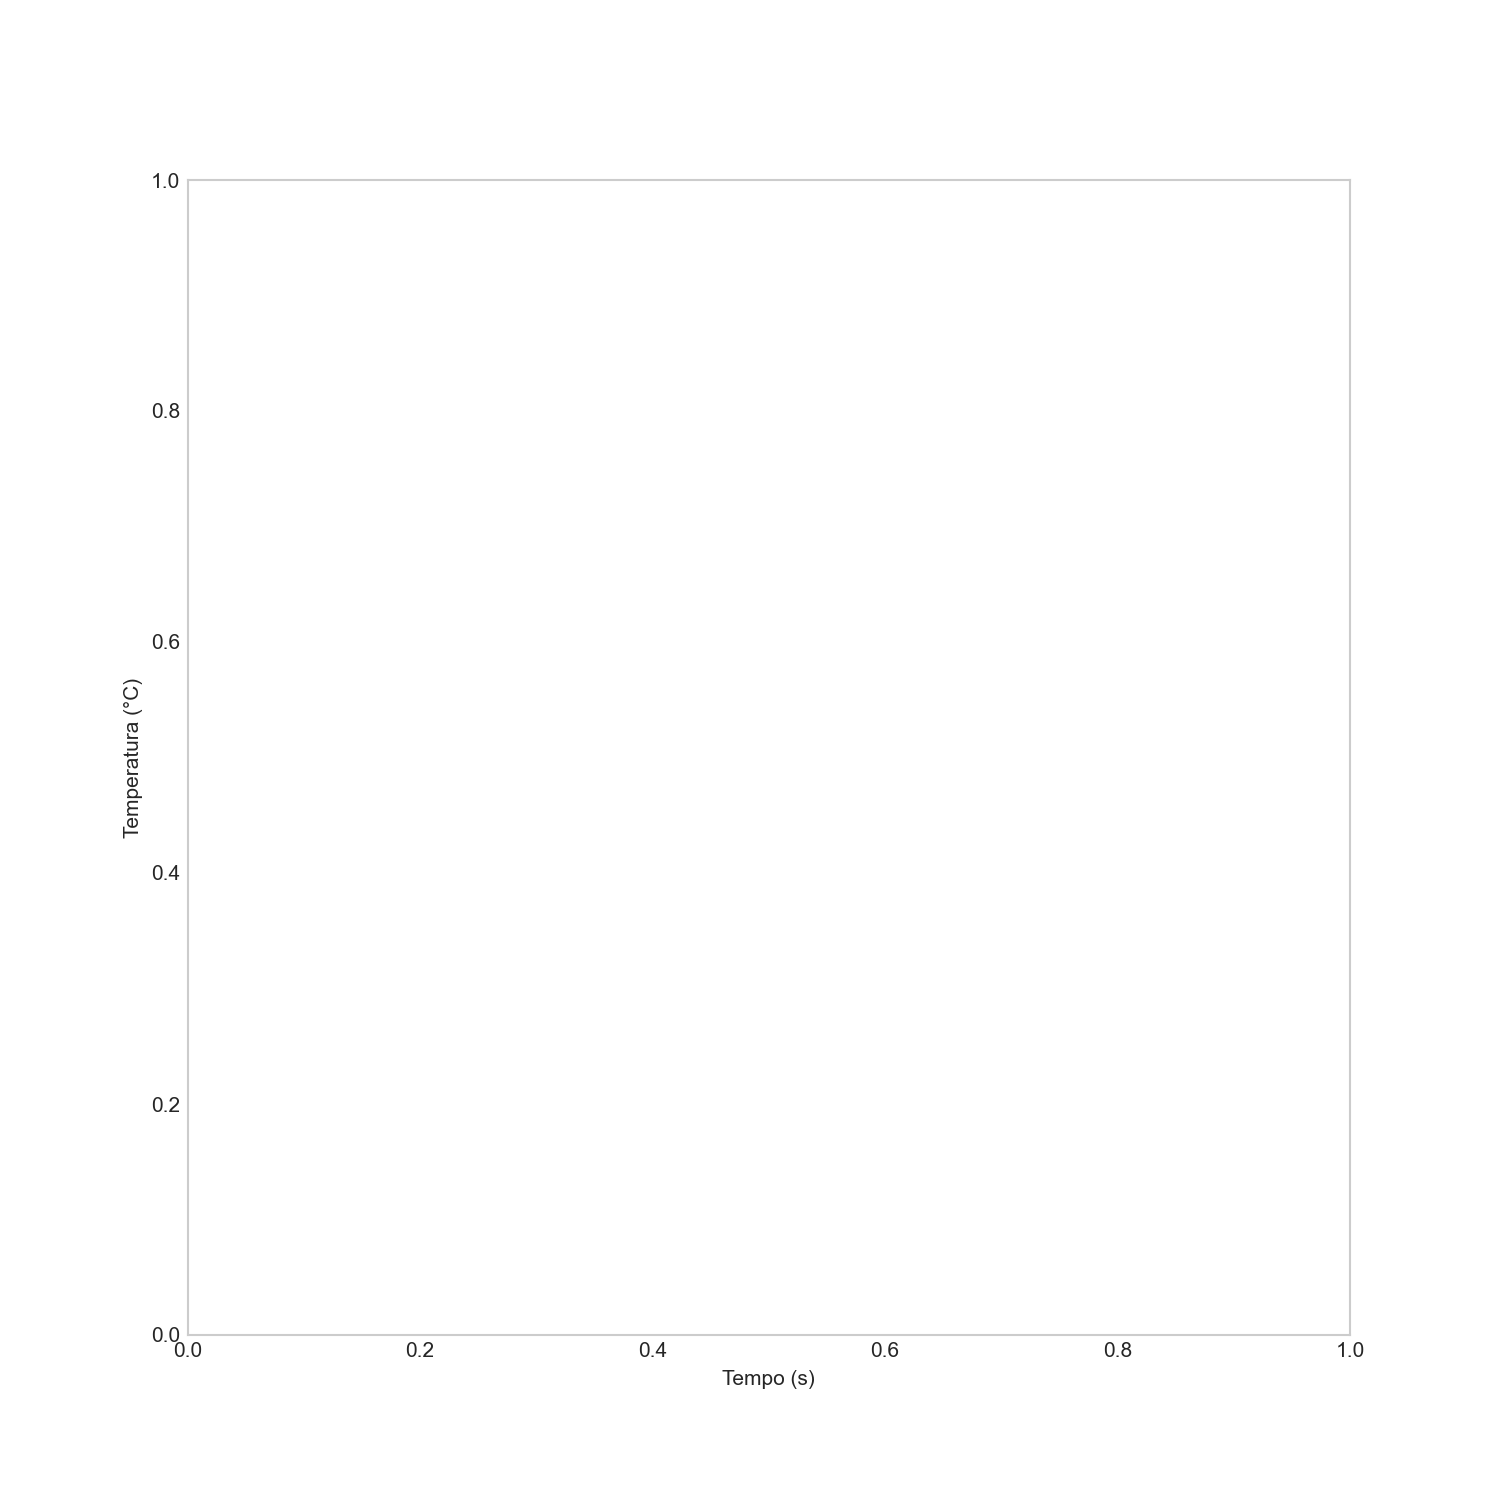

In [80]:
def new_figure():
    fig=plt.figure(figsize=[10,10])
    plt.grid()
    plt.xlabel('Tempo (s)')
    plt.ylabel('Temperatura (°C)')
    #plt.rcParams['figure.dpi'] = 150
    return fig

fig=new_figure()   

In [130]:
times = []
temps= []
getData(10,1)

[1.206, 1.837, 3.675, 5.512, 6.746, 7.98, 9.817, 11.655]


## Analisi dei dati

In [131]:
from sklearn.linear_model import LinearRegression
import numpy as np

[[0.2302437]]
[28.68055616]


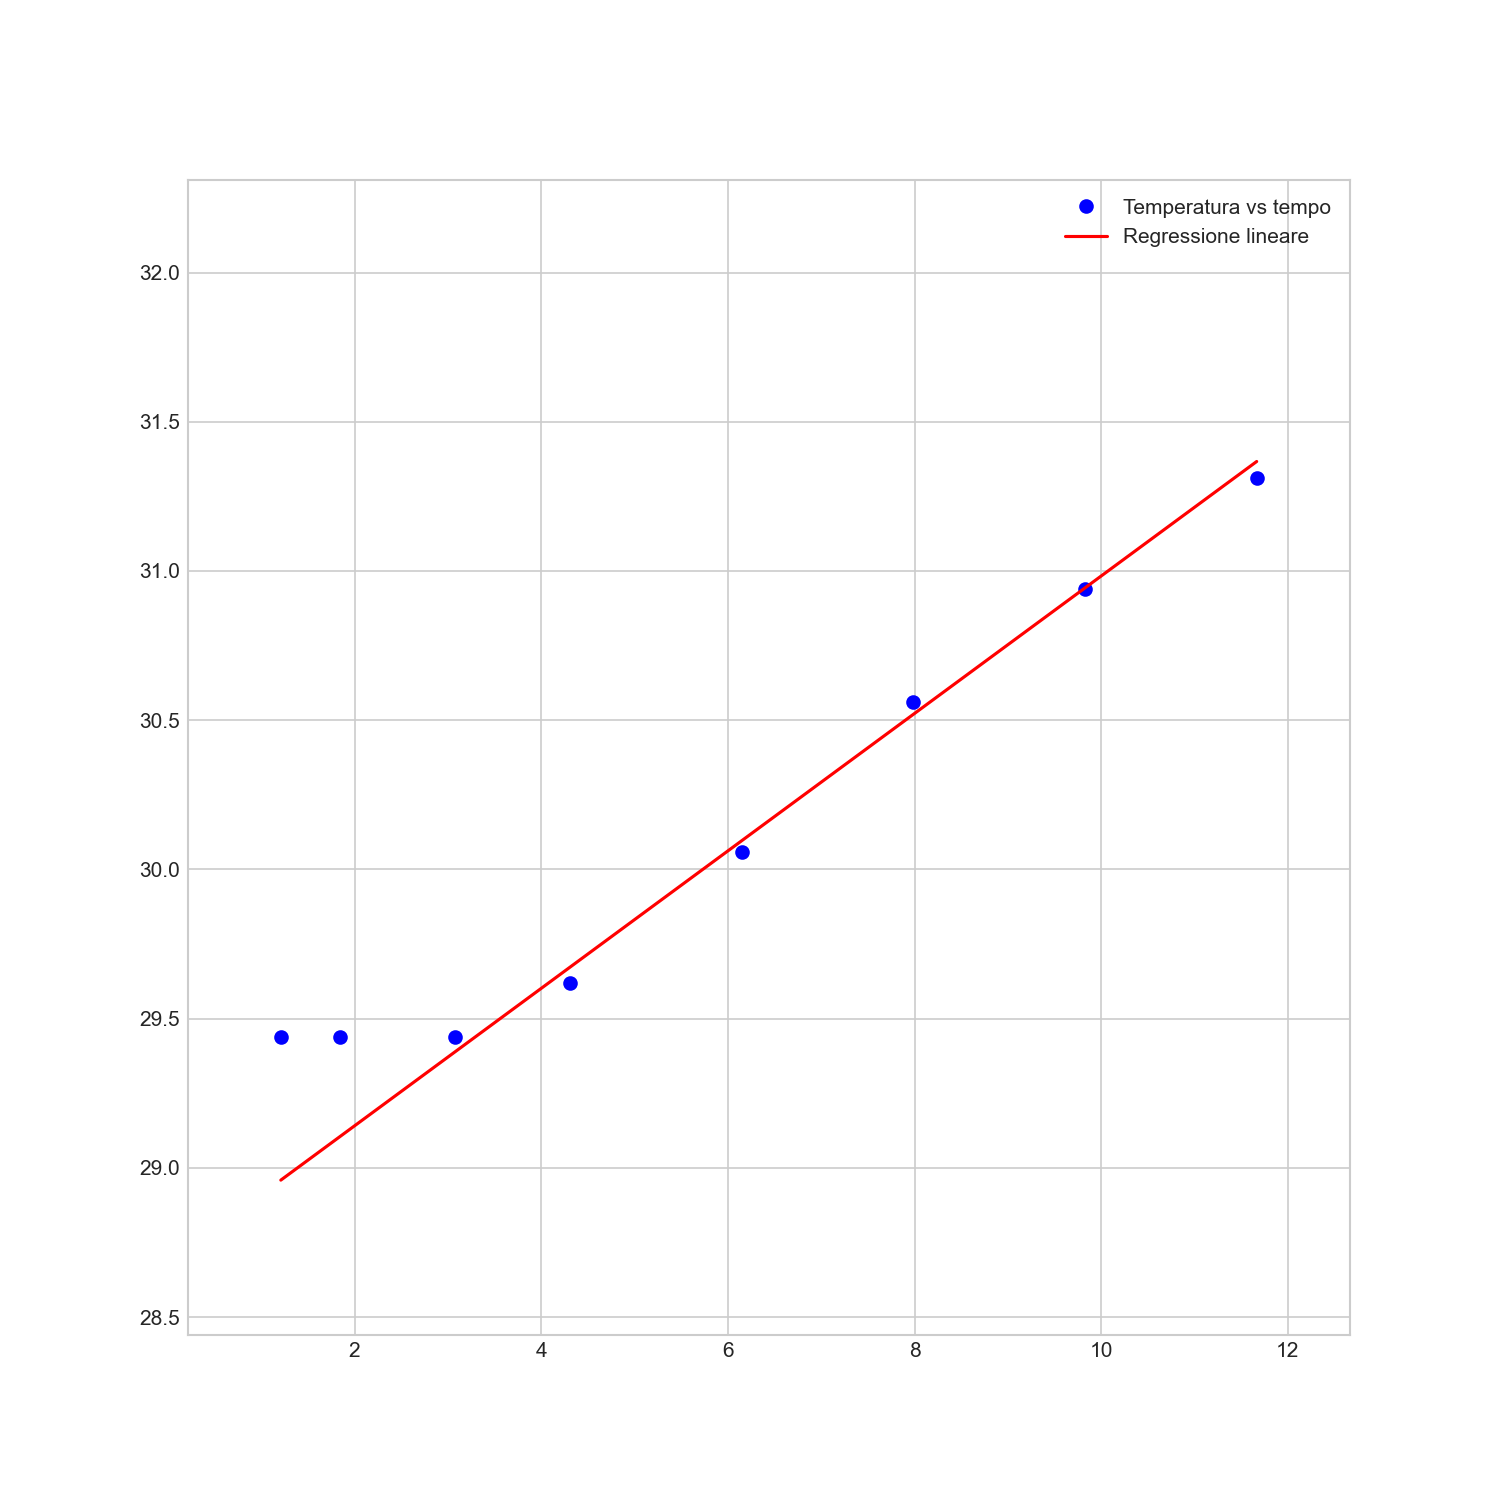

In [127]:
figure, ax = plt.subplots(figsize=[10,10])
scatter, = ax.plot([], [], 'bo', label='Temperatura vs tempo')
line, = ax.plot([], [], 'r', label='Regressione lineare')
ax.set_xlim(min(times)-1, max(times)+1)
ax.set_ylim(min(temps)-1,max(temps)+1)
ax.legend()

reg = LinearRegression()
x_train = np.array(times[2:7]).reshape(-1, 1)
y_train = np.array(temps[2:7]).reshape(-1, 1)
reg.fit(x_train,y_train)
print(reg.coef_)
print(reg.intercept_)

scatter.set_data(times,temps)
line.set_data(times, reg.predict(np.array([entry for entry in times]).reshape(-1, 1)))